In [34]:
%matplotlib inline
from matplotlib import style, figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp_resu = calc_temps('2017-08-01','2017-08-07')
print(temp_resu)

[(72.0, 79.25, 83.0)]


In [31]:
avg_temp = temp_resu[0][1]
min_temp = temp_resu[0][0]
max_temp = temp_resu[0][2]
range_temp = max_temp-min_temp

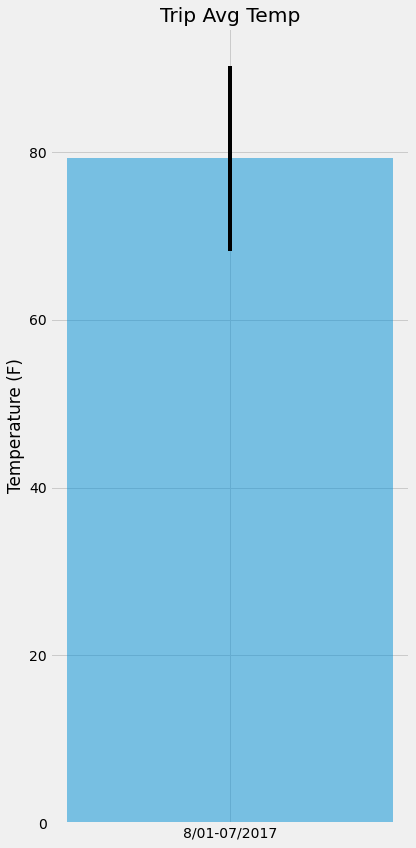

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(6,12))
ax.bar('8/01-07/2017', height = avg_temp, alpha =.5, yerr=range_temp)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.tight_layout()


### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_Results = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
                filter(Measurement.date >= '2017-08-01').\
                filter(Measurement.date <= '2017-08-07').\
                filter(Measurement.station == Station.station).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

prcp_Results

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.36, 21.3331, -157.8025, 152.4),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.22, 21.5213, -157.8374, 7.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 0.06, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.04, 21.2716, -157.8168, 3.0),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.0, 21.33556, -157.71139, 19.5)]

In [14]:
prcp_results_df = pd.DataFrame(prcp_Results, columns=["station id", "station name", "total precipitation", "latitude", "longitude", "elevation"])
prcp_results_df

,station id,station name,total precipitation,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


### Daily Temperature Normals

In [15]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [16]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2017-08-01', "%Y-%m-%d")
end_date = dt.datetime.strptime('2017-08-07', "%Y-%m-%d")

# Use the start and end date to create a range of dates
normals = []
dates_list = []

while start_date <= end_date:
    #create a list of dates for our trip
    dates_list.append(start_date)
    # Strip off the year and save a list of strings in the format %m-%d
    md = start_date.strftime("%m-%d")
    # Use the `daily_normals` function to calculate the normals for each date string 
    # and append the results to a list called `normals`.
    start_date += dt.timedelta(1)
    normals.append(*daily_normals(md))
    #print(start_date)

#shows our normals list
normals

#check to make sure our dates_list has the correct dates
#dates_list

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [17]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns = ["Min Temp", "Avg Temp", "Max Temp"])
trip_df["Date"] = pd.to_datetime(dates_list)
trip_df.set_index("Date", inplace = True)
trip_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


(0.0, 90.0)

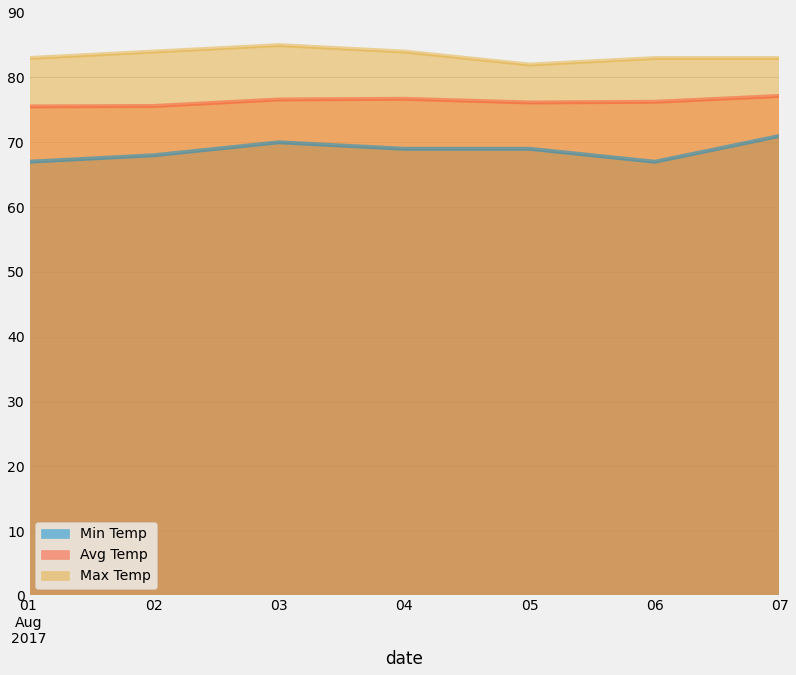

In [18]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, figsize = (12,10))
plt.xlabel("date")
plt.ylim(0,90)

## Close Session

In [19]:
session.close()